# [Inverse problem](https://en.wikipedia.org/wiki/Inverse_problem) 이란 ?
---
아래에 그림은 꺠끗한 영상 $x$ 에서 가우시안 블러가 적용된 영상 $y$ 를 생성하는 방법을 보여줍니다.

<!-- ![alt text](https://drive.google.com/uc?id=[ID OF FIGURE] "title") -->
![alt text](https://drive.google.com/uc?id=1H8baGWjYV8LFxpZFwTfcfO_skw7bX1Ab "forward model")

만약 가우시안 블러 커널이 system matrix $A$ 로 정의된다면, 가우시안 블러가 적용된 영상 $y$ 는 아래와 같이 정의될 수 있습니다.

> $y = Ax$.

여기서, ___inverse problem___ 은 가우시안 블러가 적용된 영상 $y$ 에서 디블러된 영상 $\tilde{x}$ 를 복원하는 것으로 정의될 수 있습니다.

![alt text](https://drive.google.com/uc?id=1NFEaQ6IdzFhgs5lK2pzalnTuz5Mkxgfn "inverse model")

Inverse problem 을 해결하는 간단한 방법은 system matrix/operator $A$ 의 inverse matrix/operator $A^{-1}$ 를 계산하는 것이며, 디블러된 영상 $\tilde{x}$ 는 아래와 같은 방법으로 계산될 수 있습니다.

> $\tilde{x} = A^{-1}y = A^{-1}Ax = Ix = x$.

만약 위의 방법으로 문제가 해결된다면, system matrix $A$ 는 low [condition number](https://en.wikipedia.org/wiki/Condition_number) 를 가지게 됩니다. 다시 말해, system matrix $A$ 에 의해 정의된 문제는 well-posed problem ( = well-conditioned problem ) 으로 정의할 수 있습니다. 

하지만, 일반적으로 세상에서 정의되는 system matrixes $A$ 는 a high [condition number](https://en.wikipedia.org/wiki/Condition_number) 를 가지게 되며, 이로 인해 정의된 문제는 ill-posed problem ( = ill-conditioned problem ) 으로 고려될 수 있습니다. High [condition number](https://en.wikipedia.org/wiki/Condition_number) 로 인해 정의된 ill-posed problem 은 inverse matrix $A^{-1}$ 를 직접 복원되기 어렵기 때문에, 해당 ill-posed problems 를 풀기위해 다양한 [optimization method](https://en.wikipedia.org/wiki/Mathematical_optimization) 가 개발되고 있습니다.

# 구현
---
여기서, 우리는 가우시안 블러 커널을 사용한 forward model 을 구현해 보도록 하겠습니다.

> $y = Ax$,

이때, $A$ 는 가우시안 블러 커널을 의미하며, $x$ 와 $y$ 는 깨끗한 영상과 forward model 에 의해 생성된 영상을 의미합니다.

구현하는 단계는 아래와 같습니다.

1. 패키지 추가하기
2. [2차원 가우시안 커널](https://en.wikipedia.org/wiki/Gaussian_function) 정의하기
3. System matrix $A$ 와 its [transpose](https://en.wikipedia.org/wiki/Transpose) $A^T$ 정의하기
4. 깨끗한 영상 $x$ 불러오기
5. Forward model $A$ 를 깨끗한 영상 $x$ 에 적용하기
6. 정량적 지표 계산하기
7. 영상 출력하기

## 1단계. 패키지 추가하기 

In [ ]:
# Mathmetical packages
import numpy as np
from scipy.signal import convolve

# Image processing package
from skimage import data
from skimage.transform import resize

# Metrics calculating packages
from skimage.metrics import normalized_root_mse as compare_nmse
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Ploting packages
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# Ploting options
font = {'family': 'normal',
        'weight': 'bold',
        'size': 10}

matplotlib.rc('font', **font)


## 2단계. [2차원 가우시안 커널](https://en.wikipedia.org/wiki/Gaussian_function) 정의하기

> $f(x, y) = A \exp \left( -{\left( {\frac{(x - x_0)^2}{2\sigma_X^2}} + {\frac{(y - y_0)^2}{2\sigma_Y^2}} \right)} \right),$

이때, $A$ 는 amplitude, $x_0$ 와 $y_0$ 는 중심 좌표이며, $\sigma_X$ 와 $\sigma_Y$ standard deviations 입니다.

In [ ]:
def gaus2d(nx, ny, x0=0, y0=0, sgmx=3, sgmy=3, A=1):

    x = np.linspace(-nx/2, nx/2, nx)
    y = np.linspace(-ny/2, ny/2, ny)
    x, y = np.meshgrid(x, y)

    ker = A * np.exp(-(0.5*((x - x0)/sgmx)**2 + 0.5*((y - y0)/sgmy)**2))
    ker = ker / np.sum(ker)

    return ker


## 3단계. System matrix $A$ 와 its [transpose](https://en.wikipedia.org/wiki/Transpose) $A^T$ 정의하기

__만약 여러분이 transpose 의 개념에 익숙하지 않다면, [transpose 와 관련된 저의 영상](https://www.youtube.com/watch?v=erdPhFEoFYc) 과 [wikipedia](https://en.wikipedia.org/wiki/Transpose) 를 참고해 주세요.__ 

In [ ]:
# Generate Gaussian kernel
K = 15    # size of the Gaussian kernel (*the size of kernel must be matched with 'ODD NUMBER'.)
MEAN = 0  # mean of Gaussian kernel
SGM = 3   # standard deviation of Gaussian kernel

ker = gaus2d(K, K, x0=MEAN, y0=MEAN, sgmx=SGM, sgmy=SGM)

# Define the System operator (A) and its transpose (AT)
# A: Convolution operation with Gaussian kernel
# AT: Convolution operation with fliped Gaussian kernel
A = lambda x: convolve(x, ker, mode='same')
AT = lambda y: convolve(y, np.flip(np.flip(ker, axis=0), axis=1), mode='same')


## 4단계. 깨끗한 영상 $x$ 불러오기


In [ ]:
# Load the clean image ( = ground truth )
N = 512   # number of rows for the image
M = 512   # number of colums for the image

x_gt = data.camera().astype(dtype=np.float64)/255.0
x_gt = resize(x_gt, output_shape=(N, M))


## 5단계. Forward model $A$ 를 깨끗한 영상 $x$ 에 적용하기

In [ ]:
# Generate the output from the system operator A
y = A(x_gt)


## 6단계. 정량적 지표 계산하기

1. [NMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
2. [PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
3. [SSIM](https://en.wikipedia.org/wiki/Structural_similarity)

In [ ]:
# Calculate the quantitative metrics such as NMSE, PSNR, and SSIM
x_gaus = y

nmse_gaus = compare_nmse(x_gt, x_gaus)
psnr_gaus = compare_psnr(x_gt, x_gaus)
ssim_gaus = compare_ssim(x_gt, x_gaus)

print('Result from Gaussian-blurred')
print('NSME: %.4e' % nmse_gaus)
print('PSNR: %.4f' % psnr_gaus)
print('SSIM: %.4f' % ssim_gaus)
print(' ')

Result from Gaussian-blurred
NSME: 1.1977e-01
PSNR: 24.0498
SSIM: 0.8574
 


## 7단계. 영상 출력하기

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


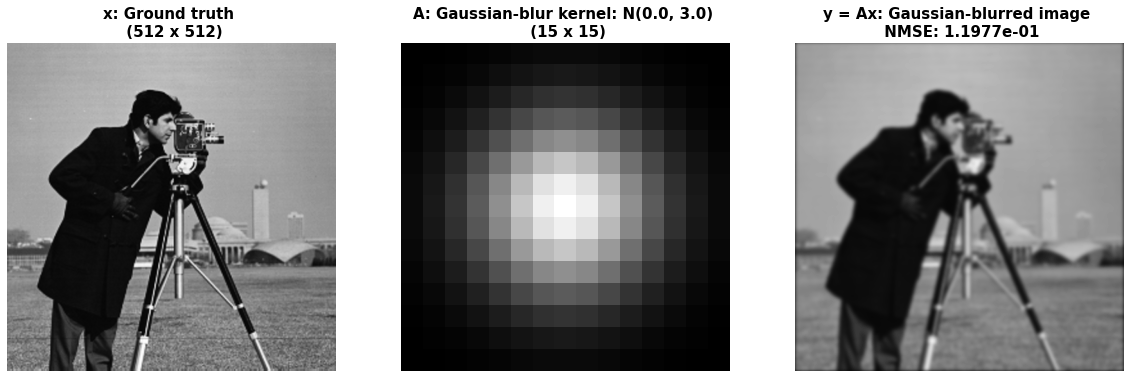

In [ ]:
# Plot the images
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 8))

axs[0].imshow(x_gt, vmin=0, vmax=1, cmap='gray')
axs[0].axis('off')
axs[0].set_title('x: Ground truth \n (%d x %d)' % (N, M), fontsize=15, fontweight='bold')

axs[1].imshow(ker, cmap='gray')
axs[1].axis('off')
axs[1].set_title('A: Gaussian-blur kernel: N(%.1f, %.1f) \n (%d x %d)' % (MEAN, SGM, K, K), fontsize=15, fontweight='bold')

axs[2].imshow(y, vmin=0, vmax=1, cmap='gray')
axs[2].axis('off')
axs[2].set_title('y = Ax: Gaussian-blurred image \n NMSE: %.4e' % (nmse_gaus), fontsize=15, fontweight='bold')

plt.show()


# 결론
---
이번 챕터에서, 우리는 inverse problem 에 관한 개념에 대해 공부해보았습니다. 일반적으로 이야기해서, inverse problem 은 system matrix/operator $A$ 에 의해서 획득된 measurement $y = Ax$ 로 부터 본래의 신호 $x$ 를 찾는 문제라고 생각하시면 됩니다.

> $y = Ax$,

이때, $y$ 는 measurement, $A$ 는 system matrix/operator 이며, $x$ 찾고자 하는 신호를 의미합니다.


# 참고자료
---

1. [Inverse problem](https://en.wikipedia.org/wiki/Inverse_problem)
2. [condition number](https://en.wikipedia.org/wiki/Condition_number)
3. [optimization problems](https://en.wikipedia.org/wiki/Mathematical_optimization)
4. [transpose](https://en.wikipedia.org/wiki/Transpose)
5. [2D Gaussian kernel](https://en.wikipedia.org/wiki/Gaussian_function)
6. [Noramlized Root Mean Square Error (NRMSE)](https://en.wikipedia.org/wiki/Root-mean-square_deviation)
7. [Peak Signal to Noise Ratio (PSNR)](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)
8. [Structural Similarity Index Measure (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity)


# 다음
---

[다음 챕터](https://colab.research.google.com/drive/1kwRveF00l0lNuR-020yA5FI-awQSK9HE?usp=sharing) 에선, 우리는 optimization method 에 대하여 알아보도록 하겠습니다.